Удалила "2 Зрелый почерк-(обычный почерк)-2.jpg" (там печатный текст)

# Const

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/Colab\ Notebooks/mest

/content/drive/MyDrive/Colab Notebooks/mest


In [ ]:
# FOLDER = "images"

# OLD_TRAIN_DIR = f"{FOLDER}/Жуковский образцы почерка"
# TRAIN_DIR = f"{FOLDER}/train"

# OLD_TEST_DIR = f"{FOLDER}/Конволюты"
# TEST_DIR = f"{FOLDER}/test"

# NEW_TRAIN_DIR = f"{FOLDER}/new_train"
# NEW_TEST_DIR = f"{FOLDER}/new_test"
# IMG_SIZE = (3024, 4032)

DATA = "data"
DATA_POS = f"{DATA}/1"
DATA_NEG = f"{DATA}/0"

BATCH_SIZE = 8

# Библиотеки

In [ ]:
import os
import re

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageOps
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 900_000_000

import random

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset

# import torchvision
from torchvision import datasets, models, transforms

from sklearn.metrics import confusion_matrix as conf_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns

def open_image(image):
    # чтобы изображение не поворачивалось на 90 градусов, если w < h
    # https://stackoverflow.com/questions/4228530/pil-thumbnail-is-rotating-my-image
    img = Image.open(image)
    img = ImageOps.exif_transpose(img)
    return img

# torchvision.transforms

In [ ]:
data_transform = transforms.Compose([
    # transforms.Resize(size=(224, 224)),
    transforms.RandomCrop(300),
    # Flip the images randomly on the horizontal
    # transforms.RandomHorizontalFlip(p=1), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])


# tranf = transforms.Compose([
#         # transforms.Resize(256), # размер каждой картинки будет приведен к 256*256
#         # transforms.CenterCrop(224), # у картинки будет вырезан центральный кусок размера 224*224
#         transforms.RandomCrop(224)
#         # transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
#         transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
#         # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # значения пикселей картинки нормализуются
#     ])

In [ ]:
# https://www.learnpytorch.io/04_pytorch_custom_datasets/

def plot_transformed_images(image_paths, transform, n=3):

    random_image_paths = random.sample(image_paths, k=n)

    # random_image_paths = image_paths

    for image_path in random_image_paths:

        f = Image.open(image_path)
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        ax[0].imshow(f)
        ax[0].set_title(f"Original \nSize: {f.size}")
        # ax[0].axis("off")

        # Transform and plot image
        # Note: permute() will change shape of image to suit matplotlib
        # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
        transformed_image = transform(f).permute(1, 2, 0)
        ax[1].imshow(transformed_image)
        ax[1].set_title(f"Transformed \nSize: {transformed_image.size()}")
        # ax[1].axis("off")

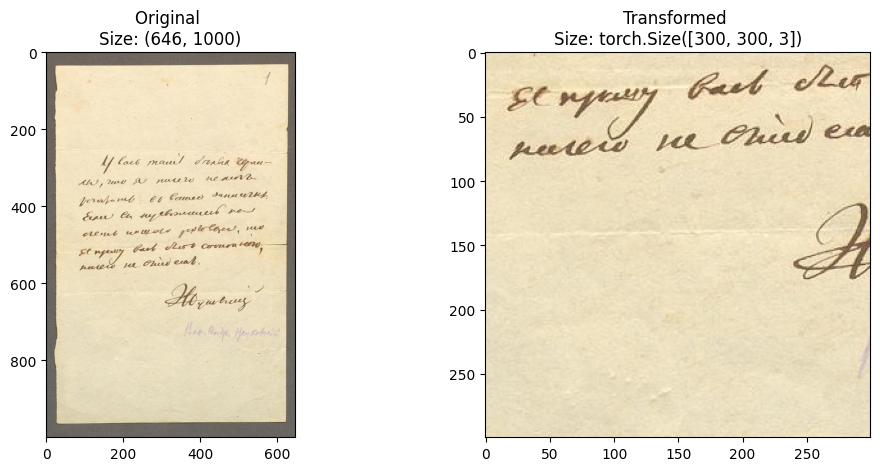

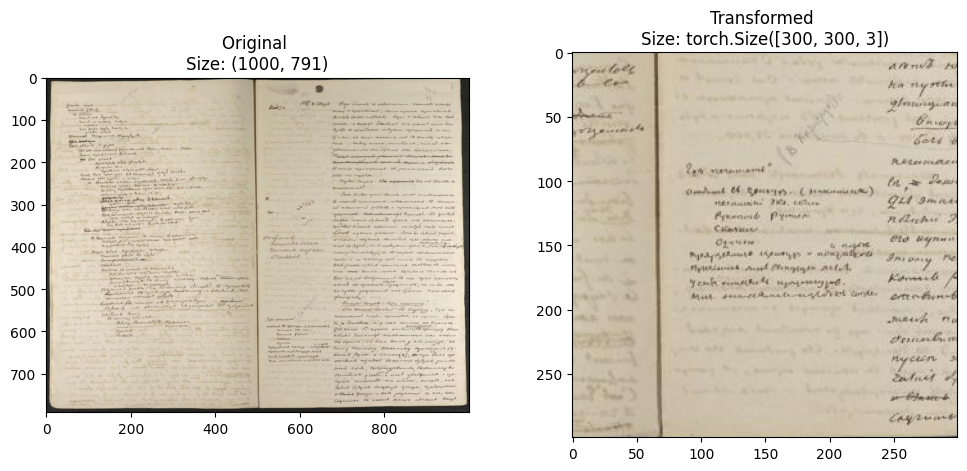

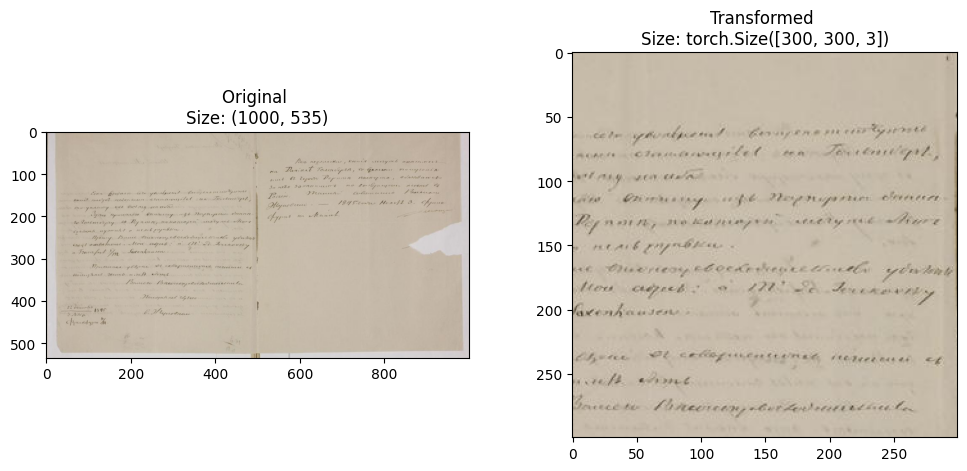

In [ ]:
files_names = sorted(os.listdir(DATA_POS))
image_paths  = [os.path.join(DATA_POS, i) for i in files_names]

plot_transformed_images(image_paths, transform=data_transform)

# Dataloader

In [ ]:
# https://stackoverflow-com.translate.goog/questions/51677788/data-augmentation-in-pytorch?_x_tr_sl=auto&_x_tr_tl=ru&_x_tr_hl=ru

# class experimental_dataset(Dataset):
#     def __init__(self, data, transform):
#         self.data = data
#         self.transform = transform

#     def __len__(self):
#         return len(self.data.shape[0])

#     def __getitem__(self, idx):
#         item = self.data[idx]
#         item = self.transform(item)
#         return item

# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor()
# ])

# x = torch.rand(8, 1, 2, 2)
# print(x)

# dataset = experimental_dataset(x, transform)

# for item in dataset:
#     print(item)


In [ ]:
def pos_neg(dataloader):
    num_pos = num_neg = num = 0

    for batch in dataloader:
        images, labels = batch

        col = images.size(0)
        pos = labels.sum()
        # print(images.size(0))

        num += col
        num_pos += pos
        num_neg += col - pos

    return {"1":num_pos.item(), "0":num_neg.item(), "total":num}

In [ ]:
class Positive_Dataset(Dataset):
    def __init__(self, images_dir, augmentation=1, transform=data_transform):
        # self.images_dir = images_dir
        self.transform = transform
        self.augmentation = augmentation

        files_names = sorted(os.listdir(images_dir))
        self.image_paths = [os.path.join(images_dir, i) for i in files_names]

        self.real_len = len(files_names)

    def __len__(self):
        return self.augmentation * len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx % self.real_len])

        # if idx < self.real_len:
        #     return transforms.ToTensor()(image), 1
        # else:
        return self.transform(image), 1


class Negative_Dataset(Dataset):
    def __init__(self, images_dir, augmentation=1, transform=data_transform):
        self.transform = transform
        self.augmentation = augmentation

        files_names = sorted(os.listdir(images_dir))
        self.image_paths = [os.path.join(images_dir, i) for i in files_names]

        self.real_len = len(files_names)

    def __len__(self):
        return self.augmentation * len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx % self.real_len])
        return self.transform(image), 0

In [ ]:
my_pos = Positive_Dataset(DATA_POS, augmentation=11)
print(f"Positive: {len(my_pos)}    ({my_pos.real_len})")

my_neg = Negative_Dataset(DATA_NEG)
print(f"Negative: {len(my_neg)}    ({my_neg.real_len})")


dataset = torch.utils.data.ConcatDataset([my_pos, my_neg])
print(f"ConcatDataset: {len(dataset)}")

Positive: 242    (22)
Negative: 224    (224)
ConcatDataset: 466


In [ ]:
# в тренировочную выборку отнесем 80% всех картинок
train_size = int(len(dataset) * 0.8)
# в валидационную — остальные 20%
val_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(
                    dataset, [train_size, val_size])

print(f"Train: {len(train_dataset)}\n Test: {len(test_dataset)}")

Train: 372
 Test: 94


In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                          shuffle=False)

print(f"Train batches: {len(train_loader)}\n Test batches: {len(test_loader)}")

Train batches: 47
 Test batches: 12


In [ ]:
pos_neg(train_loader)

{'1': 199, '0': 173, 'total': 372}

In [ ]:
pos_neg(test_loader)

{'1': 43, '0': 51, 'total': 94}

In [ ]:
images, labels = next(iter(train_loader))
print(images.shape, labels)

torch.Size([8, 3, 300, 300]) tensor([1, 1, 0, 0, 0, 1, 1, 1])


In [ ]:
def show_images(images, labels, n = 4):
    f, axes= plt.subplots(n//4, 4, figsize=(30,10))

    for i, axis in enumerate(axes):
        # переводим картинку из тензора в numpy
        img = images[i].numpy()
        # переводим картинку в размерность (длина, ширина, цветовые каналы)
        img = np.transpose(img, (1, 2, 0))

        axes[i].imshow(img)
        axes[i].set_title(labels[i].numpy())

    plt.show()

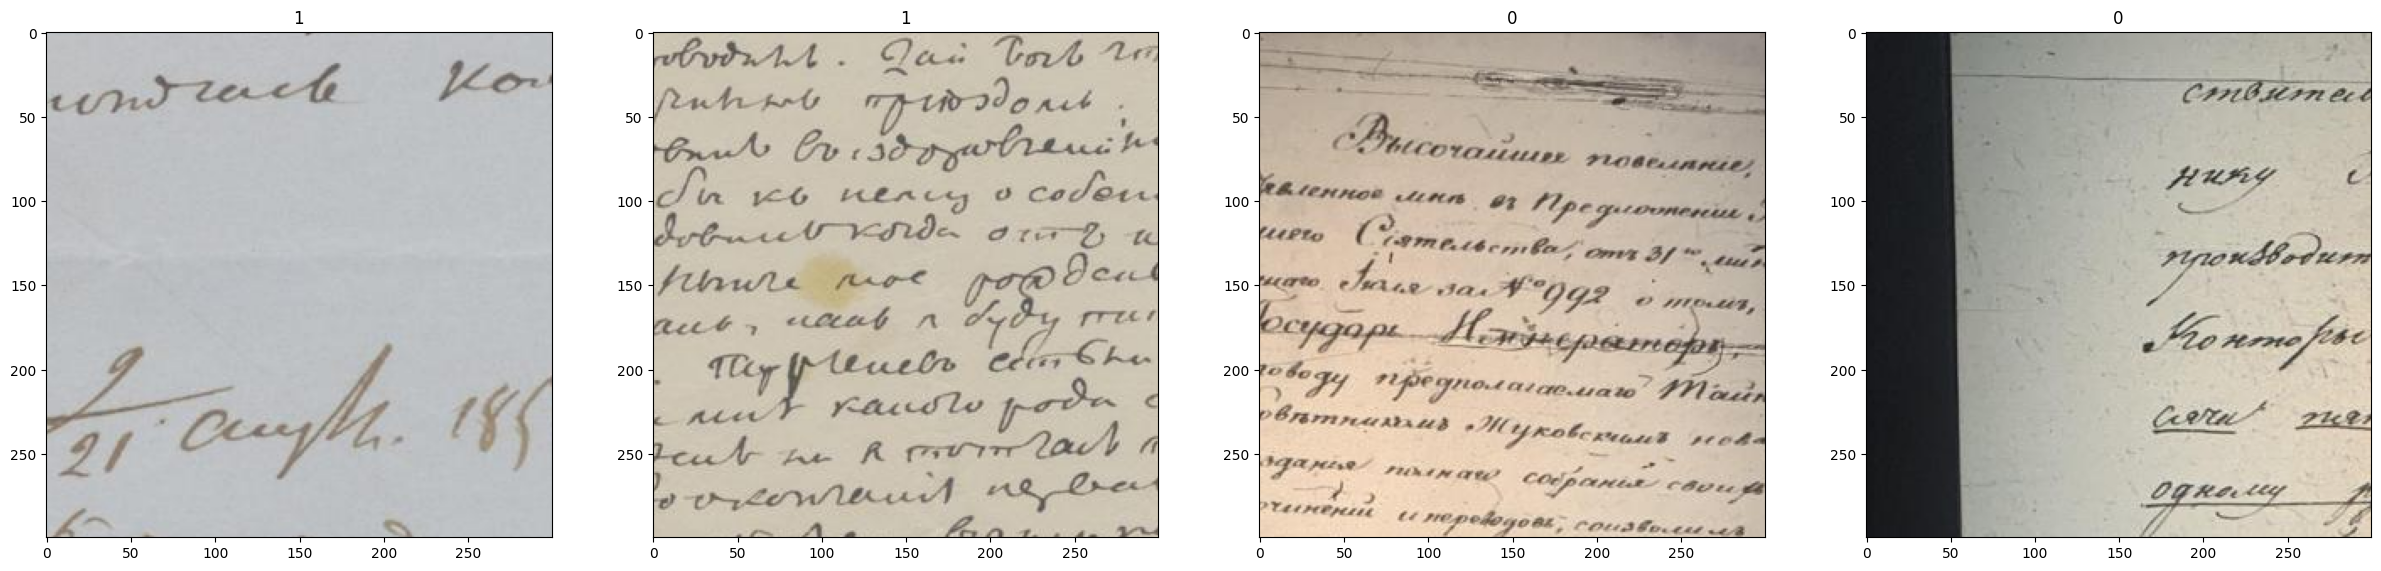

In [ ]:
show_images(images, labels)

# Код

In [ ]:
def evaluate(model, dataloader, loss_fn):

    losses = []

    num_correct = 0
    num_elements = 0

    for i, batch in enumerate(dataloader):

        # получаем текущий батч
        X_batch, y_batch = batch
        num_elements += len(y_batch)

        # эта строка запрещает вычисление градиентов
        with torch.no_grad():
            # получаем ответы сети на картинки батча
            logits = model(X_batch.to(device))

            # вычисляем лосс на текущем батче
            loss = loss_fn(logits, y_batch.to(device))
            losses.append(loss.item())

            # вычисляем ответы сети как номера классов для каждой картинки
            y_pred = torch.argmax(logits, dim=1)

            # вычисляем количество правильных ответов сети в текущем батче
            num_correct += torch.sum(y_pred.cpu() == y_batch)

    # вычисляем итоговую долю правильных ответов
    accuracy = num_correct / num_elements

    return accuracy.numpy(), np.mean(losses)

def train(model, train_loader, val_loader, loss_fn, optimizer, n_epoch=3):

    # цикл обучения сети
    for epoch in range(n_epoch):

        print("Epoch:", epoch+1)

        model.train(True)

        running_losses = []
        running_accuracies = []
        for i, batch in enumerate(train_loader):
            # получаем текущий батч
            X_batch, y_batch = batch

            # forward pass (получение ответов на батч картинок)
            logits = model(X_batch.to(device))

            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(logits, y_batch.to(device))
            running_losses.append(loss.item())

            loss.backward() # backpropagation (вычисление градиентов)
            optimizer.step() # обновление весов сети
            optimizer.zero_grad() # обнуляем веса

            # вычислим accuracy на текущем train батче
            model_answers = torch.argmax(logits, dim=1)
            train_accuracy = torch.sum(y_batch == model_answers.cpu()) / len(y_batch)
            running_accuracies.append(train_accuracy)

            # Логирование результатов
            if (i+1) % 50 == 0:
                print("Средние train лосс и accuracy на последних 50 итерациях:",
                      np.mean(running_losses), np.mean(running_accuracies), end='\n')

        # после каждой эпохи получаем метрику качества на валидационной выборке
        model.train(False)

        val_accuracy, val_loss = evaluate(model, val_loader, loss_fn=loss_fn)
        print("Эпоха {}/{}: val лосс и accuracy:".format(epoch+1, n_epoch,),
                      val_loss, val_accuracy, end='\n')

    return model

In [ ]:
# ВАШ КОД: постройте и обучите нейросеть
# model.children() выдает список сабмодулей нейросети
# в нашем случае это блоки resnet

def create_model(model, num_freeze_layers, num_out_classes):
    # замена последнего слоя сети
    model.fc = nn.Linear(512, num_out_classes)

    # заморозка слоев
    for i, layer in enumerate(model.children()):
        if i < num_freeze_layers:
            for param in layer.parameters():
                param.requires_grad = False

    return model

In [ ]:
def get_predictions(model, dataloader):
    model.eval()
    predicted_labels = []
    true_labels = []

    for i, batch in enumerate(dataloader):

        # так получаем текущий батч
        X_batch, y_batch = batch
        true_labels.append(y_batch)

        with torch.no_grad():
            logits = model(X_batch.to(device))
            y_pred = torch.argmax(logits, dim=1)
            predicted_labels.append(y_pred)

    predicted_labels = torch.cat(predicted_labels)
    true_labels = torch.cat(true_labels)
    return predicted_labels.cpu(), true_labels

# train

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
# list(model.children())

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 173MB/s]


In [ ]:
# dir(model)

In [ ]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
num_layers = len(list(model.children()))
print(f"Число слоёв: {num_layers}")
num_classes = 2
print(f"Число классов: {num_classes}")

model = create_model(model, num_layers - 1, num_classes).to(device)

Число слоёв: 10
Число классов: 2


In [ ]:
model.fc

Linear(in_features=512, out_features=2, bias=True)

In [ ]:
%time
# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate.
# вы можете экспериментировать с разными значениями learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# запустим обучение модели
# параметр n_epoch можно варьировать
model = train(model, train_loader, test_loader, loss_fn, optimizer, n_epoch=5)
torch.save(model.state_dict(), "m.pth")

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs
Epoch: 1
Эпоха 1/5: val лосс и accuracy: 0.36388544489940006 0.88297874
Epoch: 2
Эпоха 2/5: val лосс и accuracy: 0.3317762849231561 0.9574468
Epoch: 3
Эпоха 3/5: val лосс и accuracy: 0.31995623310407 0.9680851
Epoch: 4
Эпоха 4/5: val лосс и accuracy: 0.3259331298371156 0.9787234
Epoch: 5
Эпоха 5/5: val лосс и accuracy: 0.3054528335730235 0.9468085


# eval

In [ ]:
def confusion_matrix(y_true, y_pred):
    cm = conf_matrix(y_true, y_pred)

    plt.figure(figsize=(5, 3))
    sns.heatmap(cm,
                annot=True,
                fmt='g',
                xticklabels=['0','1'],
                yticklabels=['0','1'])

    plt.xlabel('Prediction',fontsize=13)
    plt.ylabel('True',fontsize=13)
    plt.title('Confusion Matrix',fontsize=17)
    plt.show()
    return cm

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                          shuffle=False)
y_pred, y_true = get_predictions(model, test_loader)
accuracy_score(y_pred, y_true)

0.9787234042553191

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                          shuffle=False)
y_pred2, y_true2 = get_predictions(model, test_loader)
accuracy_score(y_pred2, y_true2)

0.9574468085106383

In [ ]:
images, labels = next(iter(test_loader))

In [ ]:
labels

tensor([1, 1, 1, 0, 1, 0, 1, 1])

In [ ]:
loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                     shuffle=False)

X_batch, y_batch = next(iter(loader))
X_batch.shape, y_batch

(torch.Size([8, 3, 300, 300]), tensor([1, 1, 1, 1, 1, 1, 1, 1]))

In [ ]:
logits = model(X_batch.to(device))
logits, torch.softmax(logits, dim=1), torch.argmax(logits, dim=1), y_batch

(tensor([[-1.5280,  1.6455],
         [-0.6832,  0.5365],
         [-1.7756,  2.0086],
         [-2.3540,  2.0219],
         [-1.2723,  1.3616],
         [-2.0588,  2.2632],
         [-1.2595,  0.7616],
         [-1.8423,  2.2474]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.0402, 0.9598],
         [0.2280, 0.7720],
         [0.0222, 0.9778],
         [0.0124, 0.9876],
         [0.0670, 0.9330],
         [0.0131, 0.9869],
         [0.1170, 0.8830],
         [0.0165, 0.9835]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
 tensor([1, 1, 1, 1, 1, 1, 1, 1]))

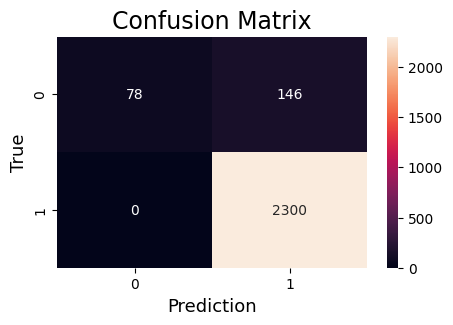

array([[  78,  146],
       [   0, 2300]])

In [ ]:
loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                     shuffle=False)

y_pred, y_true = get_predictions(model, loader)
# (y_pred == y_true).float().mean()
confusion_matrix(y_true, y_pred.cpu())

# array([[  94,  130],
#        [   0, 2300]])

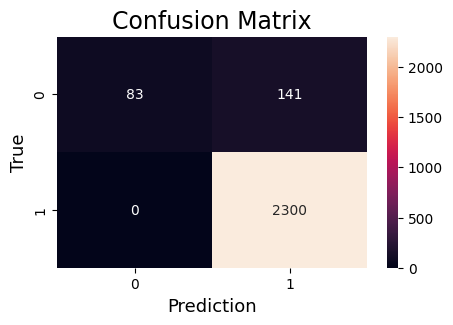

array([[  83,  141],
       [   0, 2300]])

In [ ]:
loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                     shuffle=False)

y_pred, y_true = get_predictions(model, loader)
# (y_pred == y_true).float().mean()
confusion_matrix(y_true, y_pred.cpu())

In [ ]:
# ((y_pred == 1) * (y_true == 1)).float().sum()

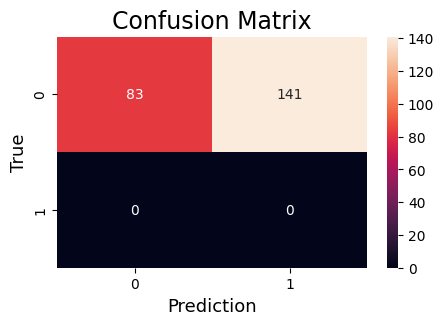

array([[ 83, 141],
       [  0,   0]])

In [ ]:
neg_loader = torch.utils.data.DataLoader(my_neg, batch_size=BATCH_SIZE,
                                          shuffle=False)

y_pred, y_true = get_predictions(model, neg_loader)
confusion_matrix(y_true, y_pred.cpu())
# array([[101, 123],
#        [  0,   0]])

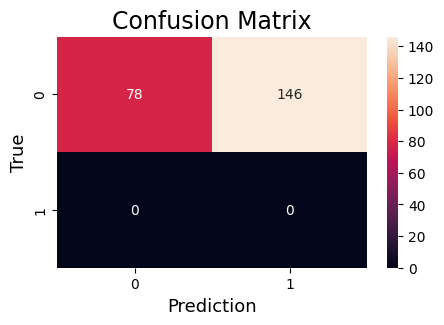

array([[ 78, 146],
       [  0,   0]])

In [ ]:
neg_loader = torch.utils.data.DataLoader(my_neg, batch_size=BATCH_SIZE,
                                          shuffle=False)

y_pred, y_true = get_predictions(model, neg_loader)
confusion_matrix(y_true, y_pred.cpu())

In [ ]:
def show_images(images, labels, n = 4):
    # f, axes= plt.subplots(n//4, 4, figsize=(30,10))
    plt.figure(figsize=(15, 10))

    for i in range(n):
        plt.subplot(n//4, 4, i + 1)
        # переводим картинку из тензора в numpy
        img = images[i]
        # переводим картинку в размерность (длина, ширина, цветовые каналы)
        img = np.transpose(img, (1, 2, 0))

        plt.imshow(img)
        plt.title(labels[i])

    plt.show()

In [ ]:
model.eval()

X_batch, y_batch = next(iter(neg_loader))

with torch.no_grad():
    logits = model(X_batch.to(device))
    y_pred = torch.argmax(logits, dim=1)

y_pred

tensor([1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')

In [ ]:
model.eval()
predicted_labels = []
true_labels = []
X = []

for i, batch in enumerate(neg_loader):
    X_batch, y_batch = batch
    true_labels.append(y_batch)

    with torch.no_grad():
        logits = model(X_batch.to(device))
        y_pred = torch.softmax(logits, dim=1)[:, 1]
        predicted_labels.append(y_pred)
        X.append(X_batch)

predicted_labels = torch.cat(predicted_labels).cpu().numpy()
true_labels = torch.cat(true_labels).numpy()
X = torch.cat(X).numpy()

In [ ]:
neg = np.where(predicted_labels <= 0.8)[0]
pos = np.where(predicted_labels > 0.8)[0]
col = 8

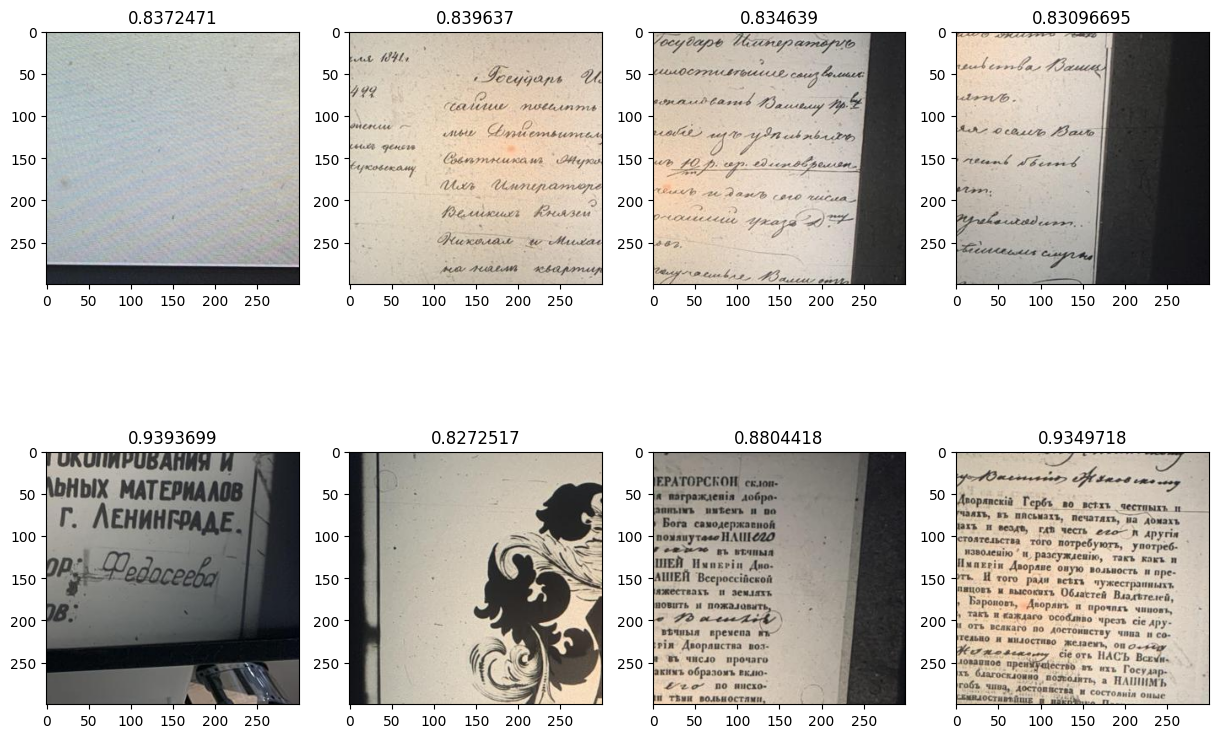

In [ ]:
show_images(X[pos[:col]], predicted_labels[pos[:col]], n = col)

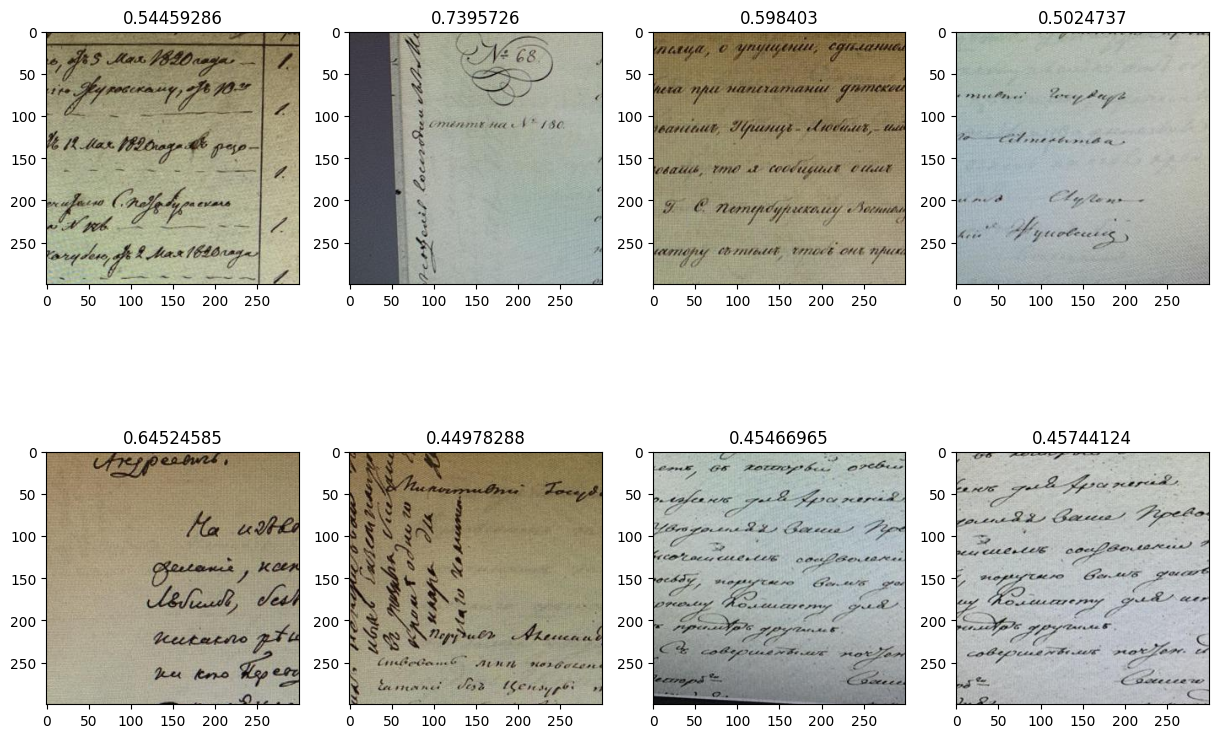

In [ ]:
show_images(X[neg[:col]], predicted_labels[neg[:col]], n = col)

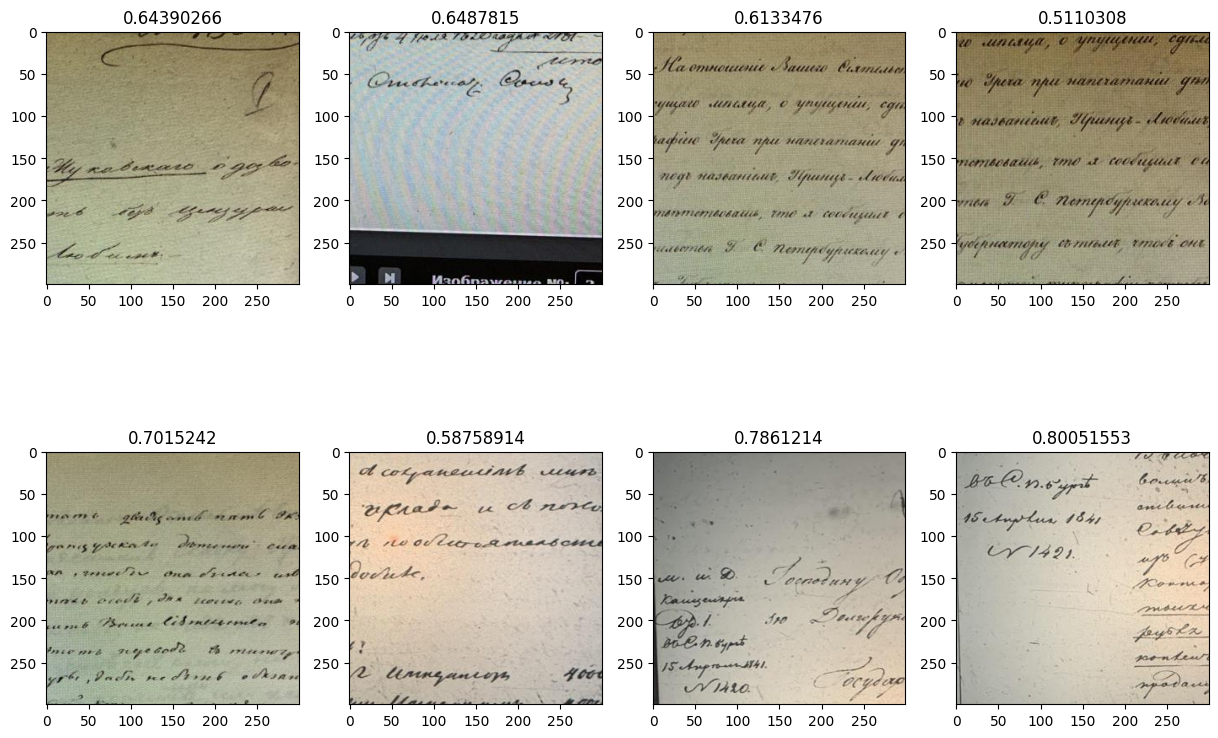

In [ ]:
show_images(X[pos[:col]], predicted_labels[pos[:col]], n = col)

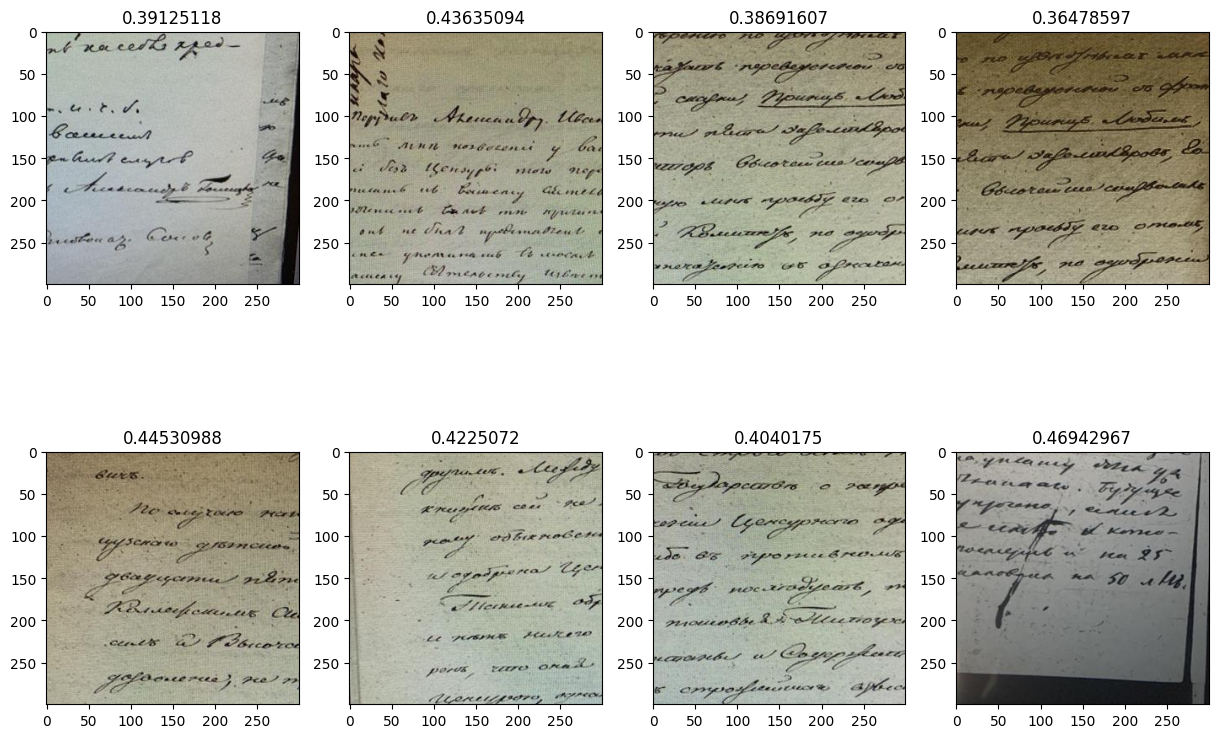

In [ ]:
show_images(X[neg[:col]], predicted_labels[neg[:col]], n = col)

In [ ]:
# my_neg.image_paths

In [ ]:
os.listdir(DATA_POS)

In [ ]:
os.listdir(DATA_NEG)